In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# Cell magic method always stays at the top of the cell

# Imports from the Python standard library should be at the top
import os
import copy
import pickle
import itertools 
import corner

# Do not import * unless you know what you are doing
import numpy as np 
import pandas as pd

import fsps
import sedpy
import lineid_plot

from sedpy.observate import getSED, vac2air, air2vac

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)

import astropy.units as u
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.constants import c, L_sun, pc
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import equivalent_width

import lineid_plot

from prospect import models
from prospect.models import priors

from scipy.stats import entropy

# re-defining plotting defaults
from matplotlib import rcParams

from dwarf_models import SDSS_EMLINES, simulate_dwarf_sed, test_single_model,\
    sigma_clipping_continuum, measure_ew_emission_line, design_model_grid,\
    generate_dwarf_population, measure_color_ew, plot_models_with_sdss, setup_fsps_spop,\
    corner_plot, entropy, data_to_distribution


ORG = plt.get_cmap('OrRd')
ORG_2 = plt.get_cmap('YlOrRd')
BLU = plt.get_cmap('PuBu')

In [2]:
sdss_cat = Table.read('/Users/runquanguan/Documents/Dwarf_SDSS_8_9_SF_v2.0.fits')

em_flag = (np.isfinite(sdss_cat['M_u']) & np.isfinite(sdss_cat['M_r']) & \
           np.isfinite(sdss_cat['M_g']) & np.isfinite(sdss_cat['M_i']) &\
           np.isfinite(sdss_cat['OIII_5007_EQW']) & \
           np.isfinite(sdss_cat['H_ALPHA_EQW']) &\
           np.isfinite(sdss_cat['H_BETA_EQW']))

sdss_use = sdss_cat[em_flag]


SDSS_EMLINES = {\
    'O_II': {'cen':3726.032, 'low':3717.0, 'upp':3737.0},\
    'O_II': {'cen':3728.815, 'low':3717.0, 'upp':3737.0},\
    'Ne_III': {'cen':3869.060, 'low':3859.0, 'upp':3879.0}, \
    'H_delta': {'cen':4101.734, 'low':4092.0, 'upp':4111.0},\
    'H_gamma': {'cen':4340.464, 'low':4330.0, 'upp':4350.0},\
    'O_III': {'cen':4363.210, 'low':4350.0, 'upp':4378.0},\
    'H_beta': {'cen':4861.325, 'low':4851.0, 'upp':4871.0},\
    'O_III': {'cen':4958.911, 'low':4949.0, 'upp':4969.0},\
    'O_III': {'cen':5006.843, 'low':4997.0, 'upp':5017.0},\
    'He_I': {'cen':5875.67, 'low':5866.0, 'upp':5886.0},\
    'O_I': {'cen':6300.304, 'low':6290.0, 'upp':6310.0},\
    'N_II': {'cen':6548.040, 'low':6533.0, 'upp':6553.0},\
    'H_lpha': {'cen':6562.800, 'low':6553.0, 'upp':6573.0},\
    'N_II': {'cen':6583.460, 'low':6573.0, 'upp':6593.0},\
    'S_II': {'cen':6716.440, 'low':6704.0, 'upp':6724.0},\
    'S_II': {'cen':6730.810, 'low':6724.0, 'upp':6744.0},\
    'Ar_III': {'cen':7135.8, 'low':7130.0, 'upp':7140.0}
}


In [3]:
fu = ascii.read('u.dat.txt')
fg = ascii.read('g.dat.txt')
fi = ascii.read('i.dat.txt')
fr = ascii.read('r.dat.txt')


In [29]:
l_w = [3728.815, 4340.464, 5006.843, 4861.325, 
       5875.67, 6300.304, 6562.8, 6730.81, 7135.8]

l_l = ['O II', 'H gamma','O III','H beta',
       'He I','O I', 'H alpha','S II','Ar III']


In [8]:
tau_arr = 2.6
const_arr = 0.3
tage_arr = 6.5
fburst_arr = 0.6
tburst_arr = 5.0
logzsol_arr = -0.8
gas_logz_arr = -0.5
gas_logu_arr = -3.2

dust1_arr = 0.1
dust2_arr = 0.0
sf_trunc_arr = 0.0



In [9]:
#absorbtion
sp = fsps.StellarPopulation(zcontinuous=1, add_neb_emission=0)
esp = fsps.StellarPopulation(zcontinuous=1, add_neb_emission=1)

sp.params['zred'] = 0
sp.params['imf_type'] = 2 
sp.params['sfh'] = 1 
sp.params['tau'] = 2.6
sp.params['const'] = 0.3
sp.params['fburst'] = 0.6
sp.params['tburst'] = 5.0
sp.params['logzsol'] = -0.8
sp.params['gas_logz'] = -0.5
sp.params['gas_logu'] = -3.2
sp.params['sf_trunc'] = 0.0
sp.params['dust1'] = 0.1
sp.params['dust2'] = 0.0

esp.params['zred'] = 0
esp.params['imf_type'] = 2 
esp.params['sfh'] = 1 
esp.params['tau'] = 2.6
esp.params['const'] = 0.3
esp.params['fburst'] = 0.6
esp.params['tburst'] = 5.0
esp.params['logzsol'] = -0.8
esp.params['gas_logz'] = -0.5
esp.params['gas_logu'] = -3.2
esp.params['sf_trunc'] = 0.0
esp.params['dust1'] = 0.1
esp.params['dust2'] = 0.0

In [10]:
lam, spec = sp.get_spectrum(peraa=True,tage=6.5) 
lam, espec = esp.get_spectrum(peraa=True, tage=6.5)

(<Figure size 1440x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80df16c9e8>)

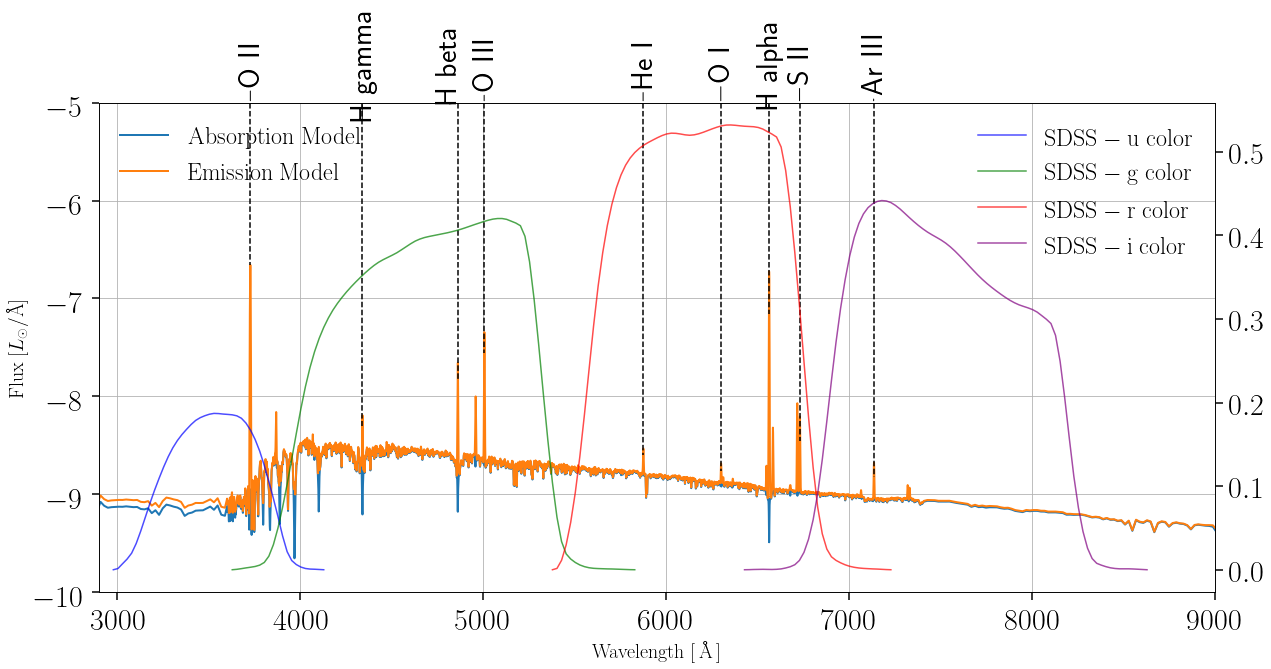

In [33]:
fig, ax = plt.subplots(1, figsize=(20,9))

ax.plot(lam, np.log(spec), label=r'$\mathrm{Absorption\; Model}$', lw=2)
ax.plot(lam, np.log(espec), label=r'$\mathrm{Emission\; Model}$', lw=2)

ax.set_xlim(2900., 9000.)
ax.set_ylim(-10, -5)
ax.legend(loc=2, frameon=False, prop={'size': 24})
ax.set_xlabel(r'$\mathrm{Wavelength}\; [\,\mathrm{\AA}\,]$', size=20)
ax.set_ylabel(r'$\mathrm{Flux} \;[L_{\odot}/\mathrm{\AA}]$', size=20)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=28)
ax.grid()

#plot filters
ax2 = ax.twinx()
ax2.plot(fu['col1'],fu['col4'],label=r'$\mathrm{SDSS-u\; color}$',c='b', alpha=0.7)
ax2.plot(fg['col1'],fg['col4'],label=r'$\mathrm{SDSS-g\; color}$',c='g', alpha=0.7)
ax2.plot(fr['col1'],fr['col4'],label=r'$\mathrm{SDSS-r\; color}$',c='r', alpha=0.7)
ax2.plot(fi['col1'],fi['col4'],label=r'$\mathrm{SDSS-i\; color}$',c='purple', alpha=0.7)
ax2.legend(loc=1, frameon=False, prop={'size': 24})
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='minor', labelsize=28)

lineid_plot.plot_line_ids(wave=lam, flux=np.log(espec), 
                          line_wave=l_w, 
                          ax=ax, line_label1=l_l,
                          label1_size=30,
                          extend= True)

In [21]:
lineid_plot.plot_line_ids?